A bare minimal implementation of diffusion model based on: https://github.com/tanelp/tiny-diffusion

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
hidden_size = 128
hidden_layers = 3
epochs = 250
learning_rate=0.001
diffusion_steps = 1000
beta_start=0.001
beta_end=0.02
beta_schedule="quadratic" # "Linear" or "quadratic"

In [3]:
def moons_dataset(n=8000):
    X, _ = make_moons(n_samples=n, random_state=42, noise=0.03)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))

dataset = moons_dataset(batch_size*epochs)
dataloader = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True)

In [4]:
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"
                ):

        self.num_timesteps = num_timesteps
        
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2
        
        self.alphas = 1.0 - self.betas
        
        # required for self.get_variance
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.step_ddpm
        self.sqrt_inv_alphas = 1 / self.alphas**0.5
        self.one_minus_alphas = self.betas
        
        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5
                
    def add_noise(self, x_start, x_noise, timesteps):
        # eq. 4 in DDPM paper.
        
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def get_variance(self, t):
        # eq. 7 in DDPM paper.
        
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step_ddpm(self, model_output, timestep, sample):
        # line 4 of algorithm 2 in DDPM paper
        
        t = timestep

        s1 = self.sqrt_inv_alphas[t]
        s2 = self.one_minus_alphas[t] / self.sqrt_one_minus_alphas_cumprod[t]
        
        pred_prev_sample = s1 * (sample - s2 * model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample
        
        
    def step_ddim(self, model_output, timestep, timestep_prev, sample, eta=1):
        # Eq 12 in DDIM paper
        
        t      = timestep
        t_prev = timestep_prev
        
        alpha_t = self.alphas_cumprod[t].reshape(-1, 1)
        alpha_t_prev = self.alphas_cumprod[t_prev].reshape(-1, 1)
        
        # formula in paragraph below Eq. 12
        sigma_t = eta * ((1-alpha_t_prev)/(1-alpha_t))**.5 * (1-(alpha_t/alpha_t_prev))**.5
        
        # predict x0
        s1 = (1-alpha_t)**.5
        s2 = alpha_t**.5
        s3 = alpha_t_prev **.5
        
        x0 = (sample - s1 * model_output) / s2
        t1 = s3 * x0
        
        # find direction pointing to xt
        s4 = (1 - alpha_t_prev - sigma_t**2)**.5
        t2 = s4 * model_output
        
        # noise
        noise = torch.randn_like(model_output)
        t3 = sigma_t * noise
        
        return t1 + t2 + t3

    def __len__(self):
        return self.num_timesteps

noise_scheduler = NoiseScheduler(
                    num_timesteps=diffusion_steps,
                    beta_start=beta_start,
                    beta_end=beta_end,
                    beta_schedule=beta_schedule
                    )

In [5]:
# model

class Block(nn.Module):
    def __init__(self, size):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))
        
class Diffusion_MLP(nn.Module):
    def __init__(self, hidden_size, hidden_layers):
        super().__init__()

        # make projection layer such that 
        # after concatenation of projected time and input
        # we get specified hidden_size
        emb_size = hidden_size//3
        self.input_mlp = nn.Linear(2, 2*emb_size)
        self.time_mlp = nn.Linear(1, hidden_size-2*emb_size)

        # layers
        layers = [Block(hidden_size) for _ in range(hidden_layers)]
        layers.append(nn.Linear(hidden_size, 2))
        self.layers = nn.Sequential(*layers)

    def forward(self, x, t):
        x_emb = self.input_mlp(x)
        t_emb = self.time_mlp(t)
        x = torch.cat((x_emb, t_emb), dim=-1)
        x = self.layers(x)
        return x
        
model = Diffusion_MLP(
                    hidden_size=hidden_size,
                    hidden_layers=hidden_layers,
                    )

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
)

 epoch 0, loss 313.7370300292969
 epoch 1, loss 0.8116291761398315
 epoch 2, loss 0.6376047134399414
 epoch 3, loss 4.379195690155029
 epoch 4, loss 0.43492770195007324
 epoch 5, loss 2.2063052654266357
 epoch 6, loss 5.068500995635986
 epoch 7, loss 0.4410449266433716
 epoch 8, loss 0.26039713621139526
 epoch 9, loss 0.3955032527446747
 epoch 10, loss 4.051263332366943
 epoch 11, loss 2.2283003330230713
 epoch 12, loss 0.33076736330986023
 epoch 13, loss 0.4277206361293793
 epoch 14, loss 0.8567913174629211
 epoch 15, loss 6.666805267333984
 epoch 16, loss 0.5354120135307312
 epoch 17, loss 0.29111620783805847
 epoch 18, loss 0.833602786064148
 epoch 19, loss 1.026753544807434
 epoch 20, loss 1.2402817010879517
 epoch 21, loss 0.6822784543037415
 epoch 22, loss 1.4688003063201904
 epoch 23, loss 4.023962020874023
 epoch 24, loss 0.25598520040512085
 epoch 25, loss 0.28992077708244324
 epoch 26, loss 0.444187730550766
 epoch 27, loss 1.1002672910690308
 epoch 28, loss 0.546146869659423

 epoch 228, loss 0.2141132354736328
 epoch 229, loss 0.20600880682468414
 epoch 230, loss 0.21482384204864502
 epoch 231, loss 0.21288226544857025
 epoch 232, loss 0.21175862848758698
 epoch 233, loss 0.20274530351161957
 epoch 234, loss 0.20810312032699585
 epoch 235, loss 0.20840731263160706
 epoch 236, loss 0.20617736876010895
 epoch 237, loss 0.20264780521392822
 epoch 238, loss 0.20934933423995972
 epoch 239, loss 0.2074887752532959
 epoch 240, loss 0.20519843697547913
 epoch 241, loss 0.2061239629983902
 epoch 242, loss 0.21145926415920258
 epoch 243, loss 0.2052299827337265
 epoch 244, loss 0.2073243111371994
 epoch 245, loss 0.2069624662399292
 epoch 246, loss 0.2048877328634262
 epoch 247, loss 0.21210528910160065
 epoch 248, loss 0.20935556292533875
 epoch 249, loss 0.2076074182987213


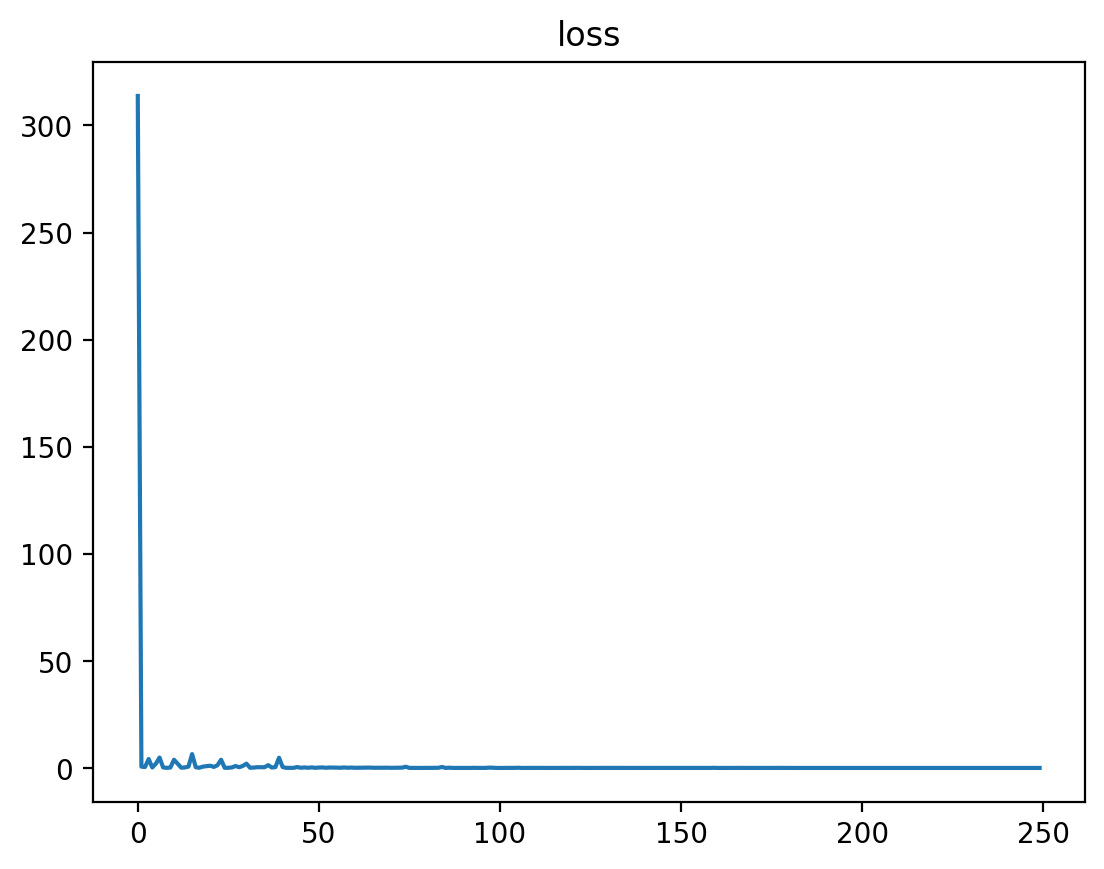

In [6]:
# Training

model.train()
avg_loss = []

for epoch in range(epochs):
    epoch_loss = []
    for batch_id, (data) in enumerate(dataloader):

        # prepare data
        data = data[0]
    
        noise = torch.randn_like(data)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (data.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(data, noise, timesteps)
        noise_pred = model(noisy, timesteps[:,None].float())
        loss = F.mse_loss(noise_pred, noise)
        epoch_loss.append(loss.item())

        # backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # visualize prediction result
        if False: #(epoch%10==0) and (batch_id==0):
            clean_data = remove_noise(data_with_noise, noise_pred.detach(), alpha_t_dash_[:,None])
            plt.figure(figsize=(5,5))
            plt.scatter(data[:,0].cpu(), data[:,1].cpu(), label='target')
            plt.scatter(data_with_noise[:,0].cpu(),data_with_noise[:,1].cpu(), label='input: target with noise')
            plt.scatter(clean_data[:,0].cpu(),clean_data[:,1].cpu(), label='predicted')
            plt.title(f'epoch = {epoch}')
            plt.legend()
            plt.show()
            
    avg_loss.append(torch.tensor(epoch_loss).mean())
    print(f' epoch {epoch}, loss {avg_loss[-1]}')
    
plt.figure()
plt.plot(avg_loss)
plt.title("loss")
plt.show()

## sampling using DDPM

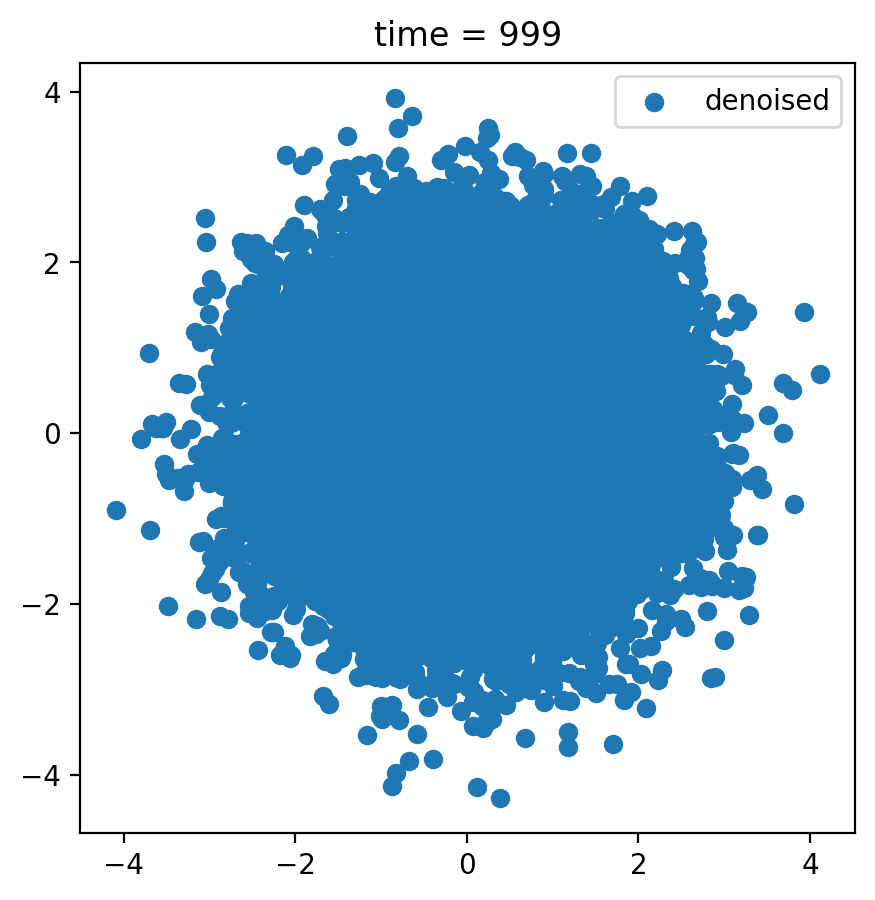

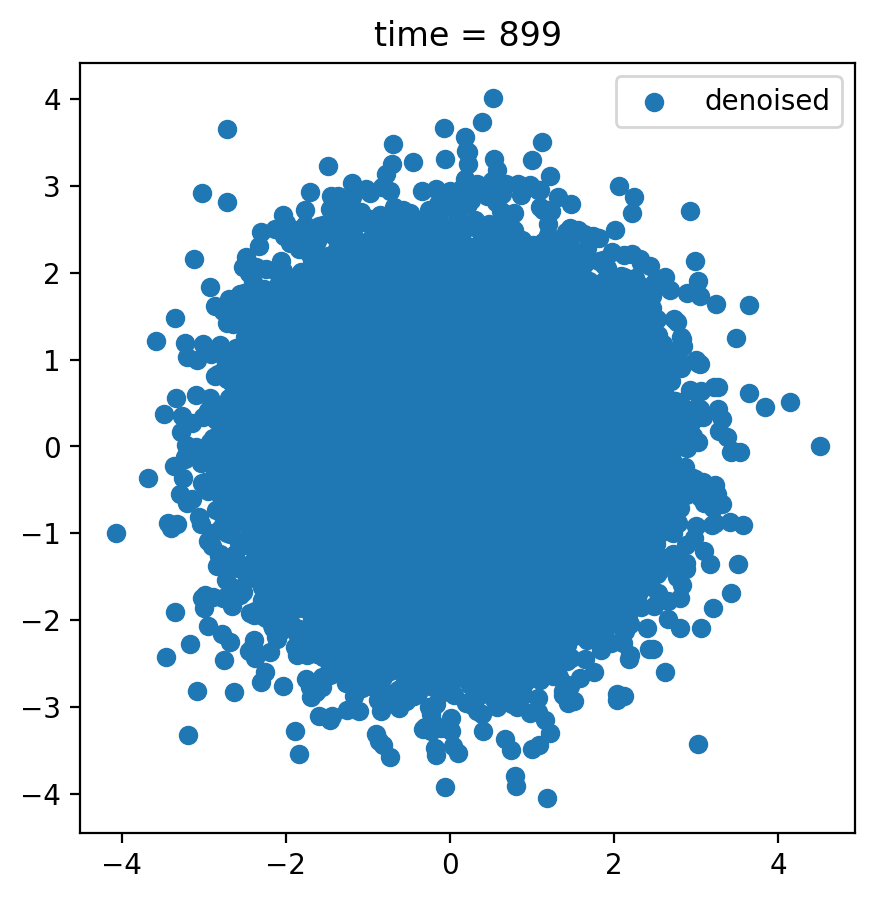

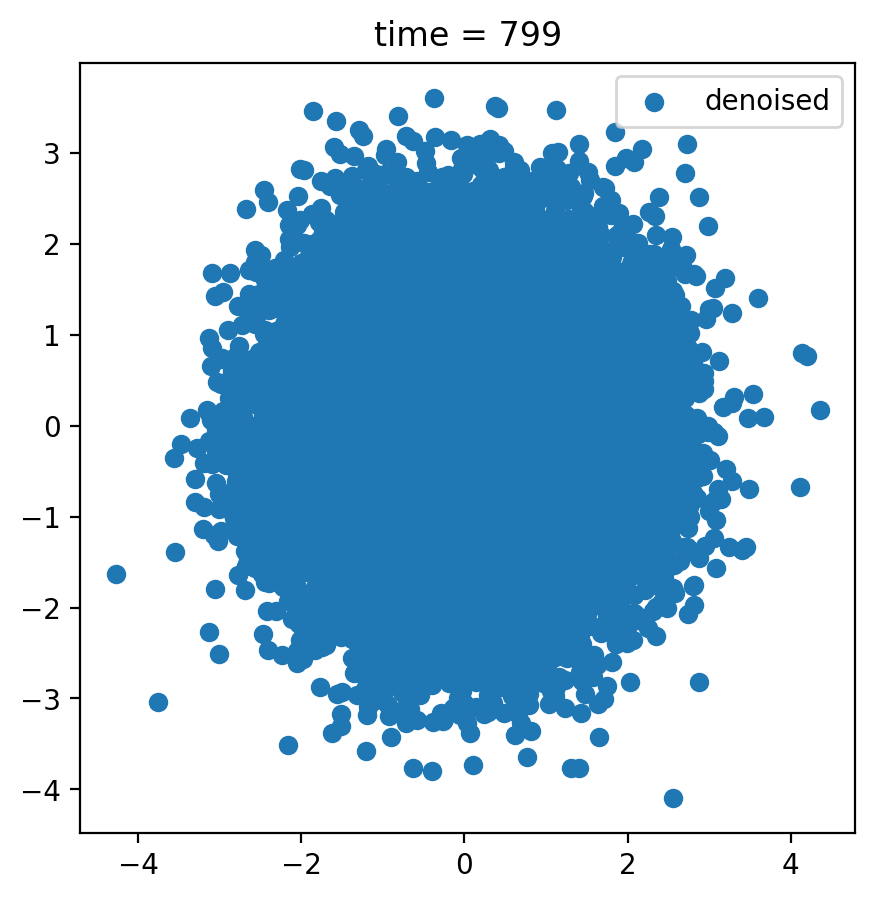

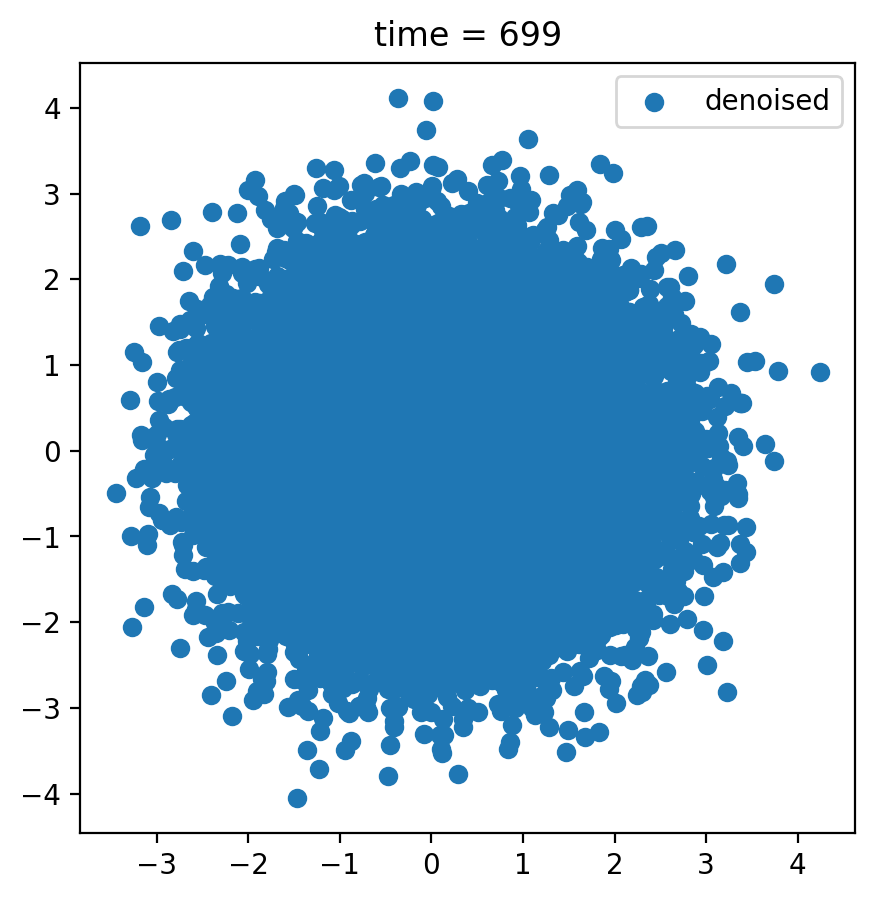

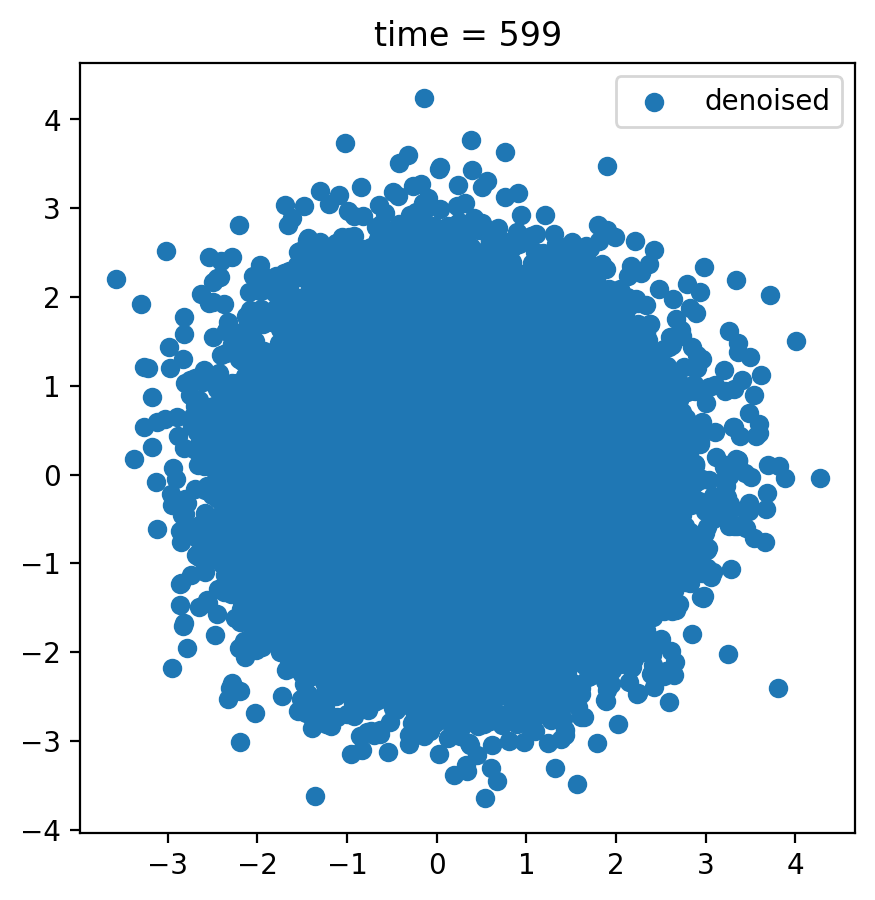

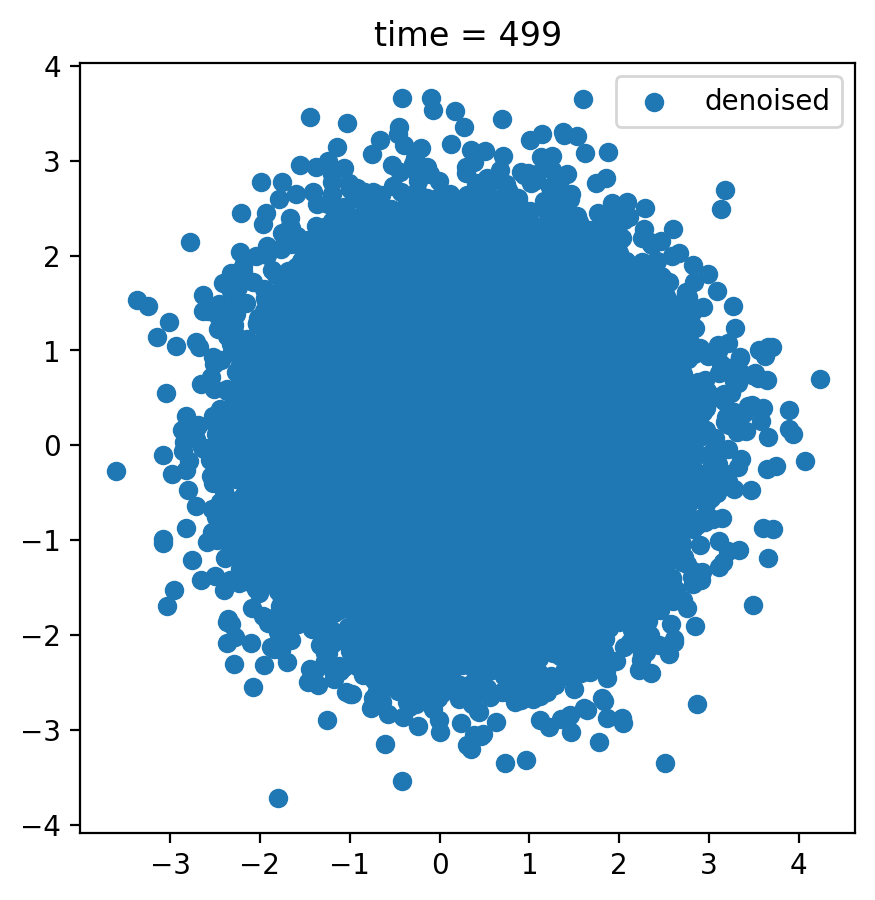

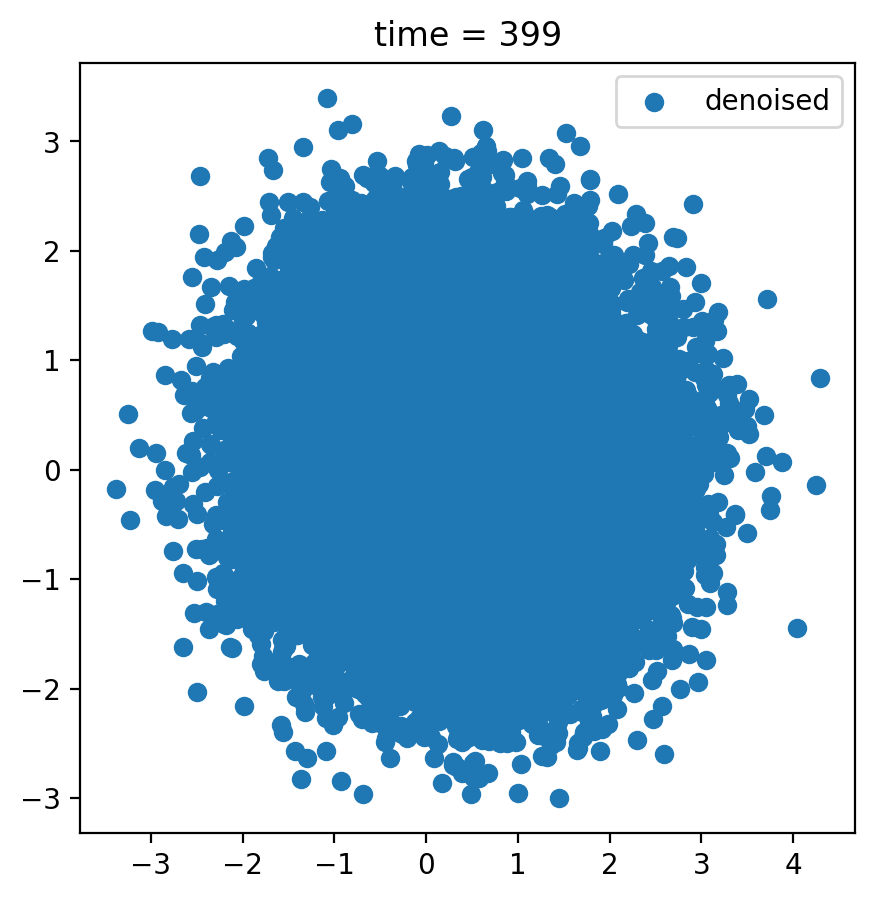

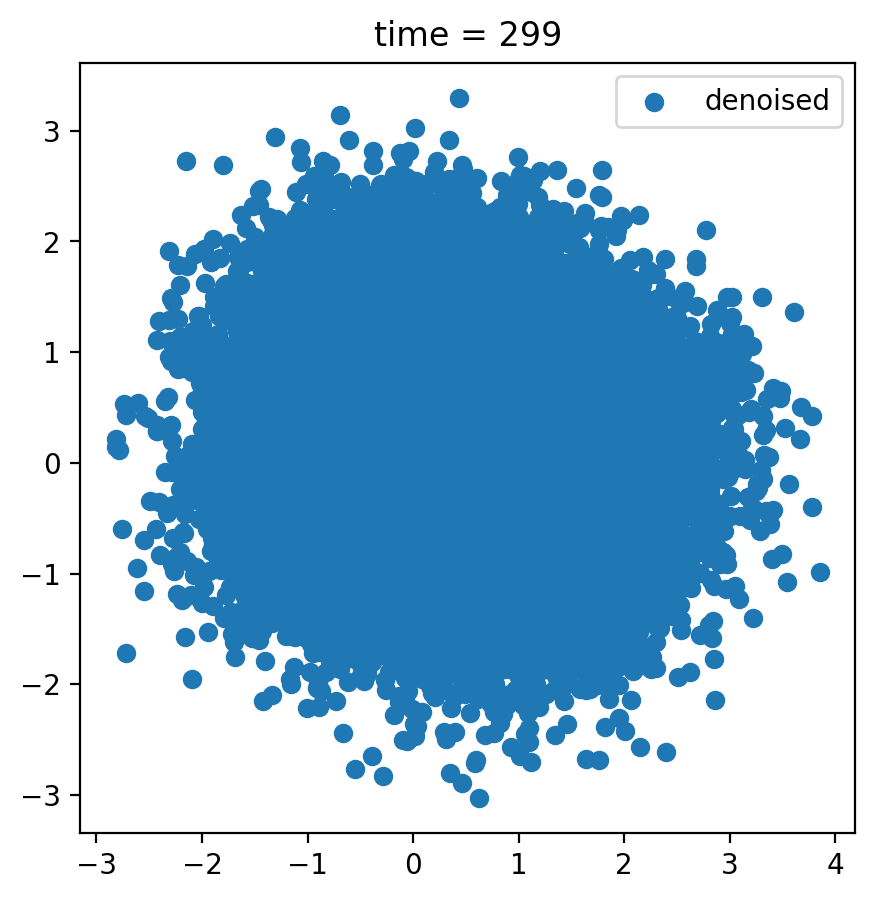

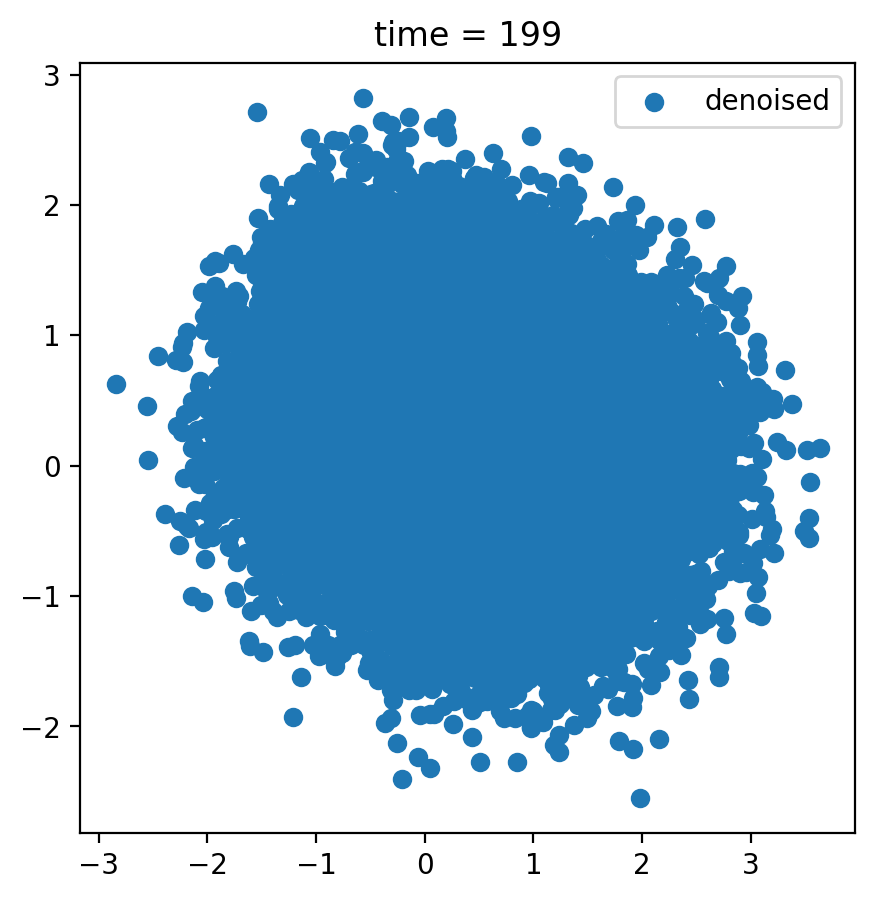

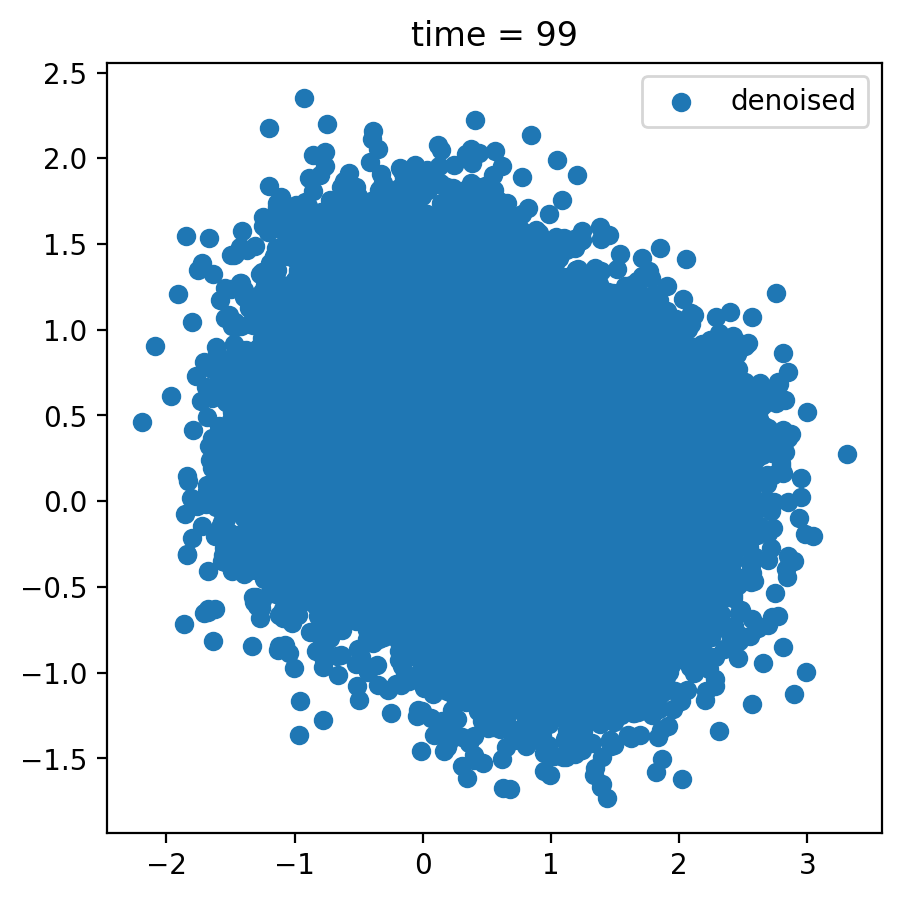

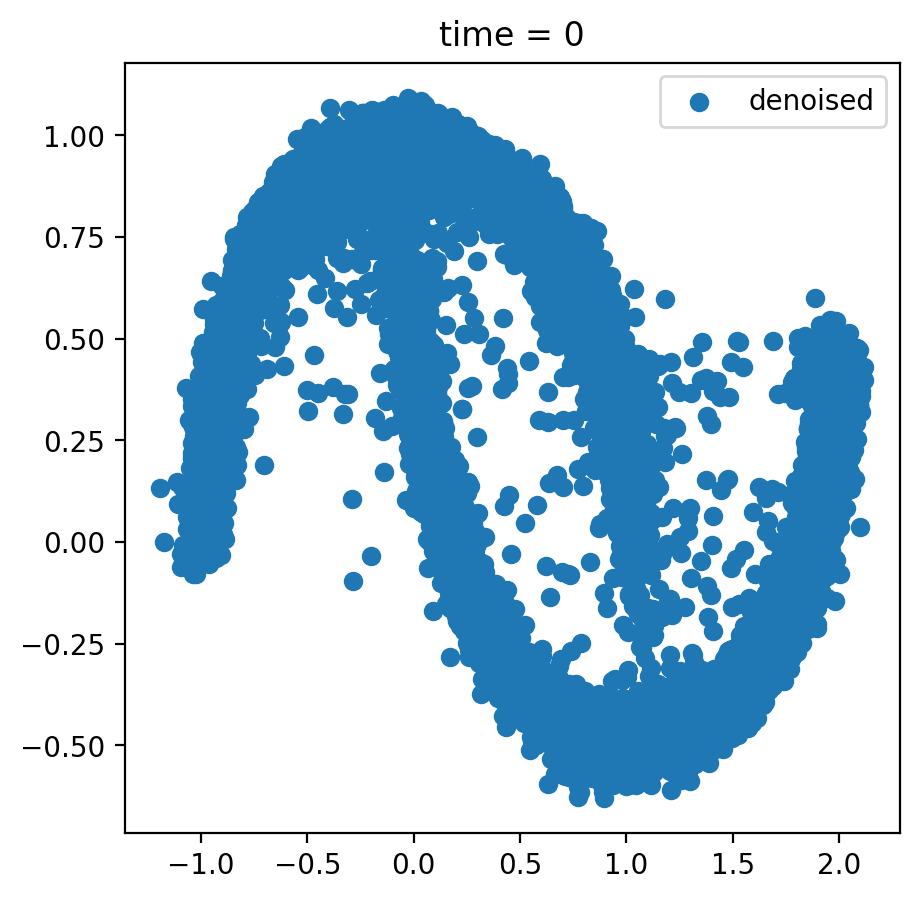

In [7]:
# Evaluation

model.eval()
eval_points = batch_size * epochs
sample = torch.randn(eval_points, 2)
orig_sample = sample.clone()
timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(timesteps):
    time = torch.from_numpy(np.repeat(t, eval_points)).long()
    with torch.no_grad():
        residual = model(sample, time[:,None].float())
    sample = noise_scheduler.step_ddpm(residual, time[0], sample)
    
    # visualize prediction result
    if (i%100 == 0) or (i==(len(timesteps)-1)):    
        plt.figure(figsize=(5,5))
        plt.scatter(sample[:,0].cpu(), sample[:,1].cpu(), label='denoised')
        plt.title(f'time = {t}')
        plt.legend()
        plt.show()

[-1  0  1]


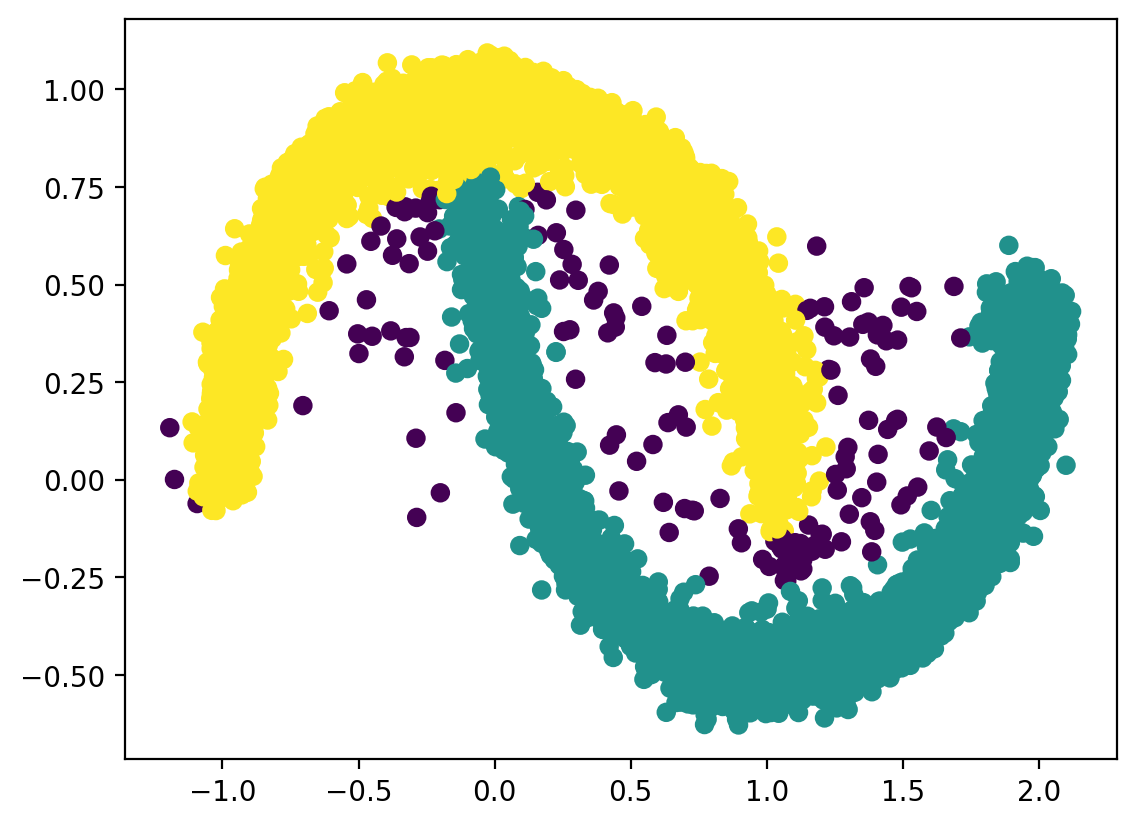

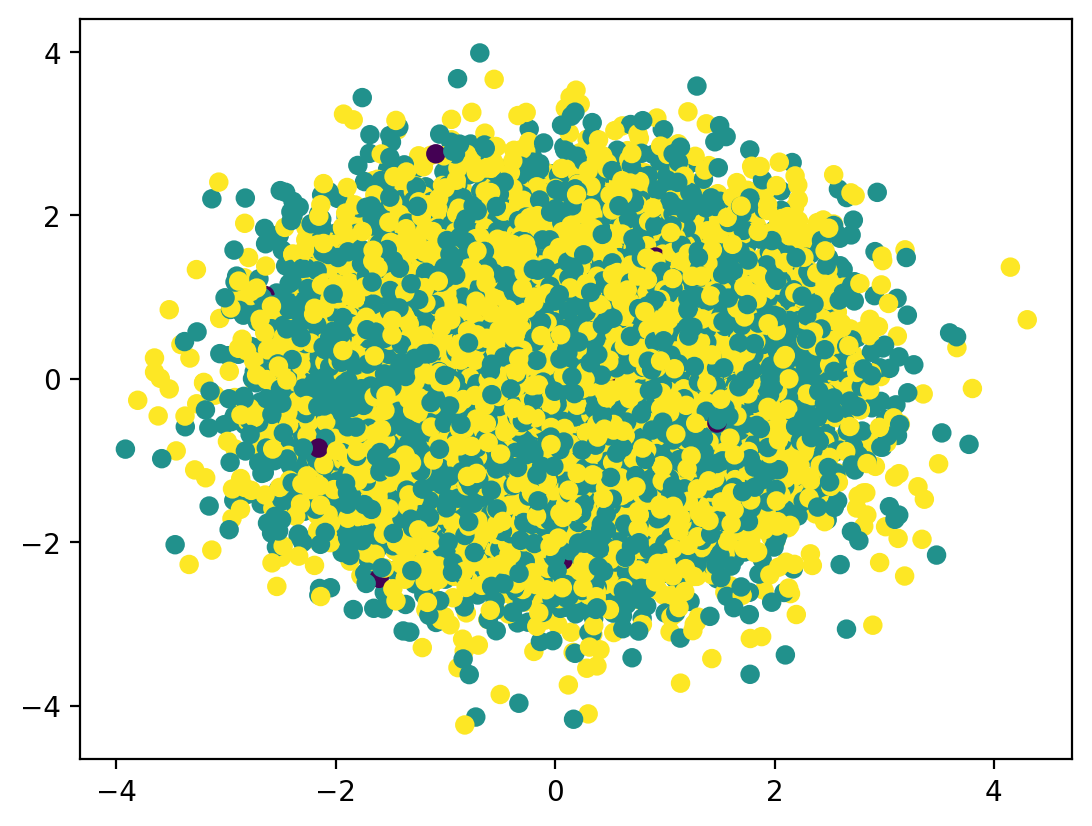

In [8]:
# visualize

clustering = DBSCAN(eps=0.1, min_samples=100).fit(sample.numpy())
labels = clustering.labels_

print(np.unique(labels))
plt.scatter(sample[:,0], sample[:,1], c=labels)
plt.show()

plt.scatter(orig_sample[:,0], orig_sample[:,1], c=labels)
plt.show()

## sampling using DDIM

reducing steps from 1000 to 200


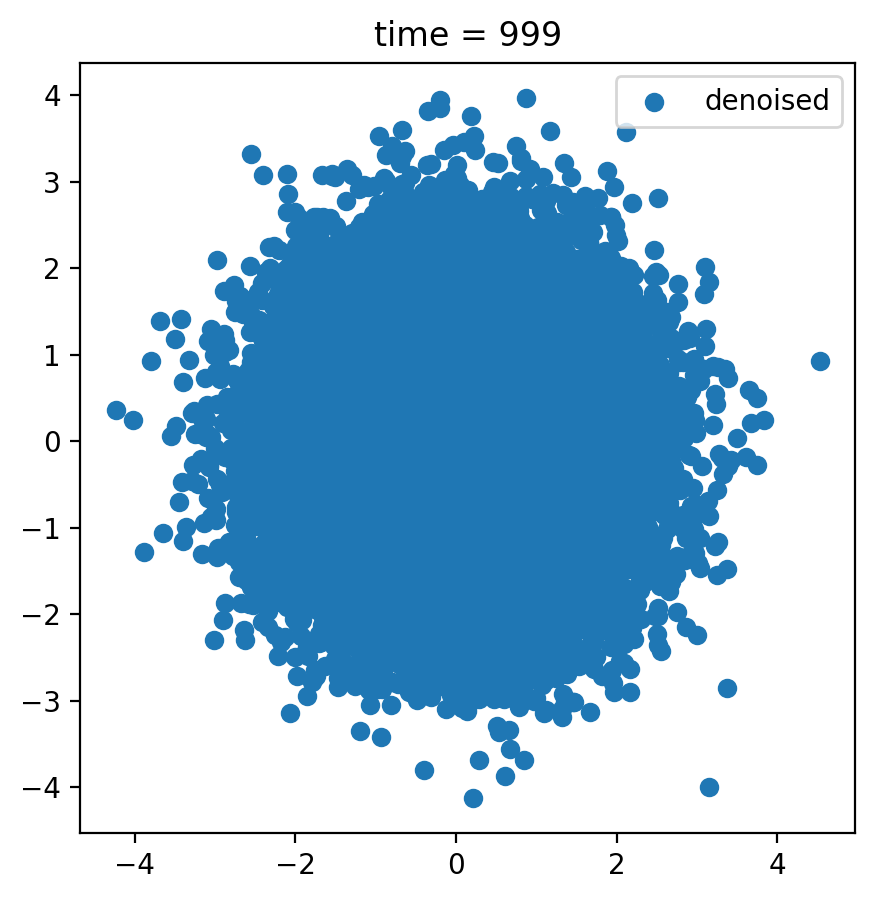

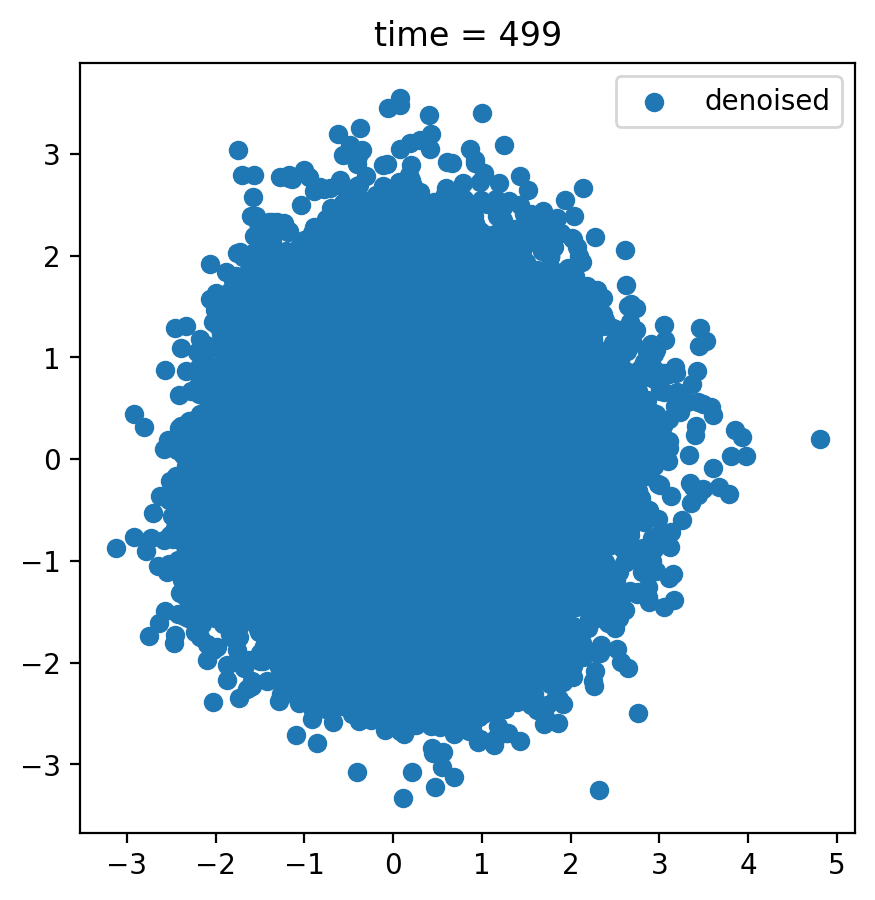

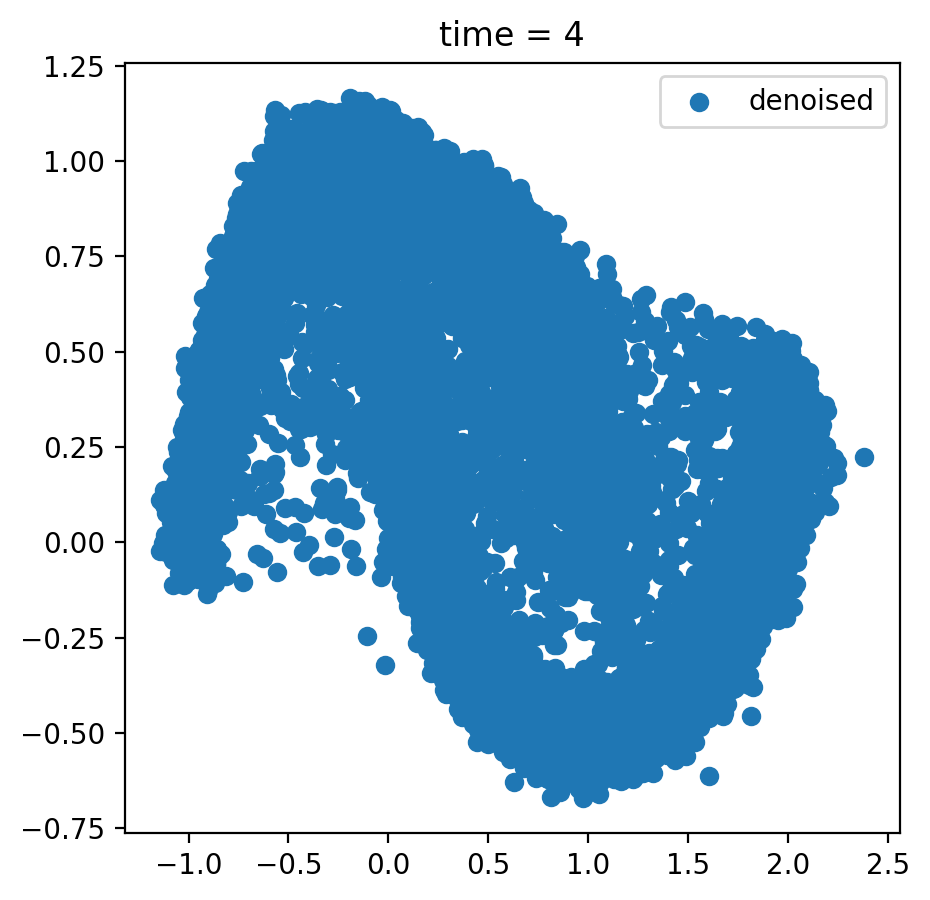

In [9]:
# Evaluation

model.eval()
eval_points = batch_size * epochs
sample = torch.randn(eval_points, 2)
orig_sample = sample.clone()

timesteps = list(range(len(noise_scheduler)))[::-5]
timesteps_prev = timesteps[1:] + [0]

print(f'reducing steps from {diffusion_steps} to {len(timesteps)}')
for i, (t, t_prev) in enumerate(zip(timesteps, timesteps_prev)):
    time = torch.from_numpy(np.repeat(t, eval_points)).long()
    time_prev = torch.from_numpy(np.repeat(t_prev, eval_points)).long()
    with torch.no_grad():
        residual = model(sample, time[:,None].float())
        
    # eta = 1 DDIM = DDPM -> non-deterministic
    # eta = 0 -> deterministic
    sample = noise_scheduler.step_ddim(residual, time, time_prev, sample, eta=0)
    
    # visualize prediction result
    if (i%100 == 0) or (i==(len(timesteps)-1)):    
        plt.figure(figsize=(5,5))
        plt.scatter(sample[:,0].cpu(), sample[:,1].cpu(), label='denoised')
        plt.title(f'time = {t}')
        plt.legend()
        plt.show()

[-1  0  1]


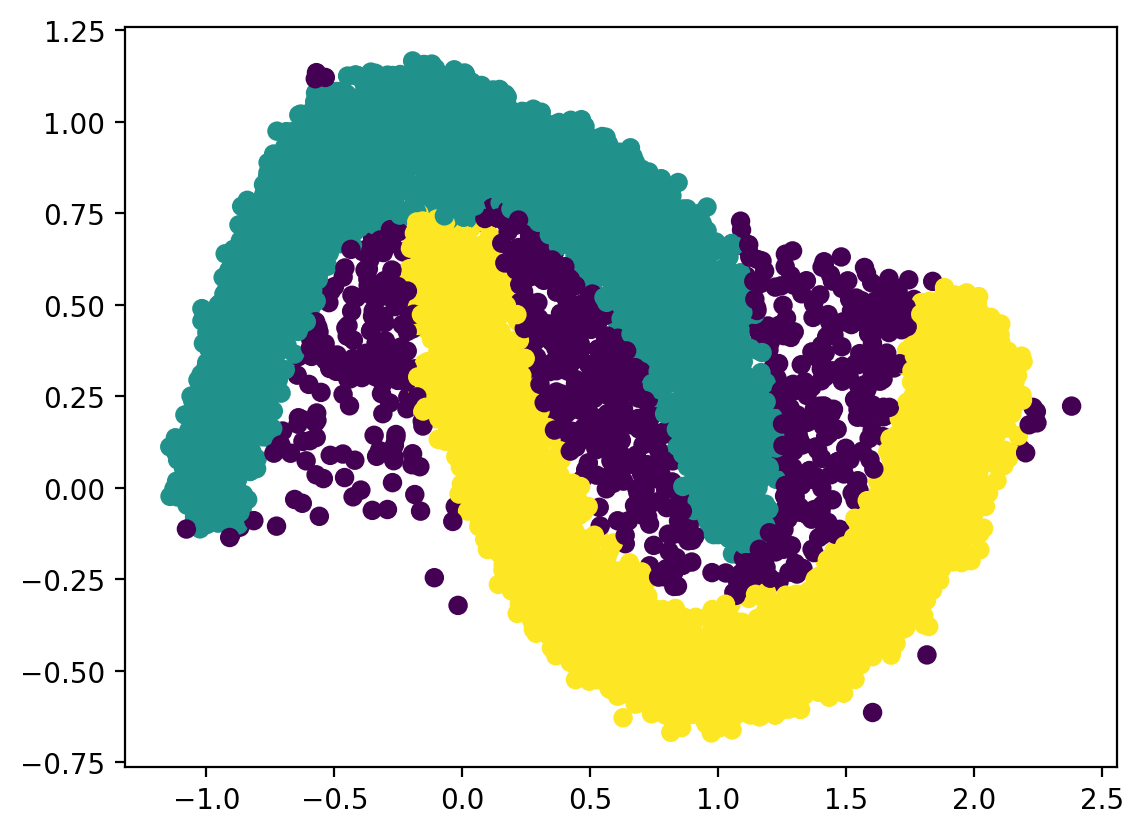

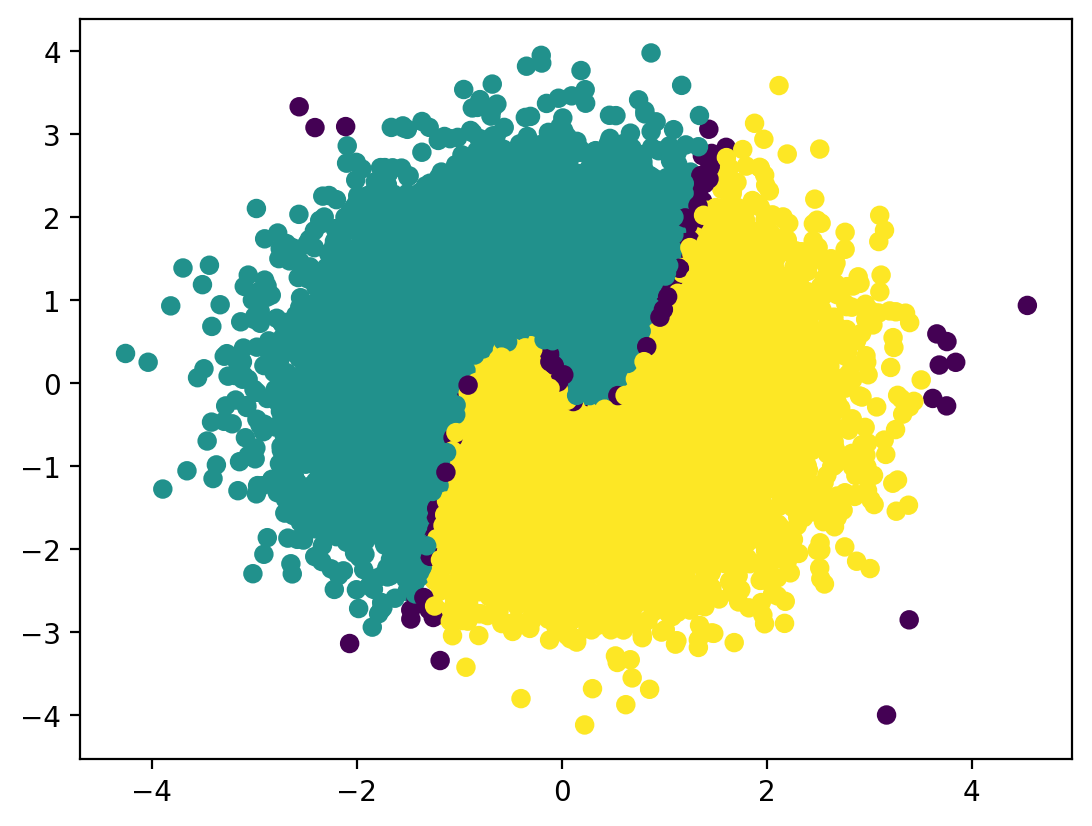

In [14]:
# visualize

clustering = DBSCAN(eps=0.09, min_samples=100).fit(sample.numpy())
labels = clustering.labels_

print(np.unique(labels))
plt.scatter(sample[:,0], sample[:,1], c=labels)
plt.show()

plt.scatter(orig_sample[:,0], orig_sample[:,1], c=labels)
plt.show()